In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Model building with scikit-learn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [2]:
# January data
df_jan = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")

In [3]:
# February data
df_feb = pd.read_parquet("./data/yellow_tripdata_2023-02.parquet")

## Q1
How many columns are there in the January data?

In [4]:
print(f"There are {df_jan.columns.size} columns in the January data")

There are 19 columns in the January data


Let's compute the duration of the trips, in minutes.

In [5]:
def compute_min(dr):
    return dr.total_seconds() / 60


def compute_trip_duration(df: pd.DataFrame) -> pd.Series:
    duration = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    return duration.apply(compute_min)

In [6]:
df_jan["duration"] = compute_trip_duration(df_jan)

## Q2
What is the standard deviation of the trip times for January?

In [7]:
std = df_jan["duration"].std()
print(f"The standard deviation of trip durations for Jan: {np.round(std,2)}")

The standard deviation of trip durations for Jan: 42.59


## Q3
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

Before dropping the outliers it's helpful to visualize them. Let's do a simple box plot to do so. We set the scale to be logarithmic to ensure we can see the distribution.

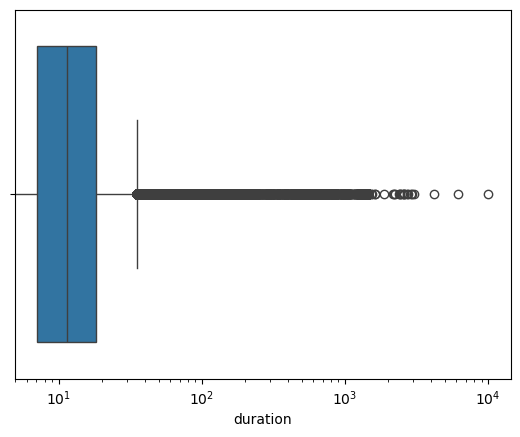

In [8]:
sns.boxplot(x=df_jan["duration"])
ax = plt.gca()
ax.set_xscale("log")

Indeed there are some pretty large outliers, with some trips listed to have taken $>1000$ min $=16$ hours

In [9]:
cond = (df_jan["duration"] >= 1) & (df_jan["duration"] <= 60)
df_jan_clean = df_jan[cond]

In [10]:
df_jan_clean = df_jan_clean.reindex()
ratio = df_jan_clean.shape[0] / df_jan.shape[0]

In [11]:
print(
    f"The fraction of records left after removing outliers is {np.round(ratio,2)*100}%"
)

The fraction of records left after removing outliers is 98.0%


## Q4
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
What's the dimensionality of this matrix (number of columns)?

In [12]:
categorical = ["PULocationID", "DOLocationID"]

In [13]:
df_jan_clean[categorical] = df_jan_clean[categorical].astype(str)

In [14]:
train_dicts = df_jan_clean[categorical].to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [15]:
print(f"The number of columns in the design matrix is {X_train.shape[1]}")

The number of columns in the design matrix is 515


We can easily sanity check this: one-hot encoding should create a vector for every feature where the number of components equals to the number of unique values for that feature. Since we have 2 features in our model, we just have to figure out the sum of the number of unique elements for those columns.

In [16]:
tmp1 = df_jan_clean["DOLocationID"].unique()
tmp2 = df_jan_clean["PULocationID"].unique()

In [17]:
print(
    f"Sanity check: the sum of the number of unique elements for 2 features is {tmp1.shape[0]+tmp2.shape[0]}"
)

Sanity check: the sum of the number of unique elements for 2 features is 515


## Q5
Now let's use the feature matrix from the previous step to train a model.
What's the RMSE on train?

In [18]:
target = "duration"
y_train = df_jan_clean[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_train)
RMSE_train = root_mean_squared_error(y_train, y_pred)
print(f"The RMSE on training set is {np.round(RMSE_train,2)}")

The RMSE on training set is 7.65


## Q6
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [20]:
def preprocess_data(df: pd.DataFrame):

    df["duration"] = compute_trip_duration(df)
    cond = (df["duration"] >= 1) & (df["duration"] <= 60)
    df = df[cond]
    return df

In [21]:
# Preprocess the validation data
df_feb = preprocess_data(df_feb)

In [22]:
# We need to preprocess the test data in the same way

df_feb[categorical] = df_feb[categorical].astype(str)
val_dicts = df_feb[categorical].to_dict(orient="records")
# Note the "transform" and not "fit_transform"!
X_val = dv.transform(val_dicts)
y_val = df_feb["duration"]


y_pred = lr.predict(X_val)
RMSE_val = root_mean_squared_error(y_val, y_pred)

In [23]:
print(f"The RMSE on validation set is {np.round(RMSE_val,2)}")

The RMSE on validation set is 7.81


In [24]:
%load_ext watermark
%watermark

Last updated: 2024-05-16T08:01:05.456118+00:00

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-1060-gcp
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [25]:
%watermark --iversions

numpy     : 1.26.4
matplotlib: 3.8.4
seaborn   : 0.13.2
pandas    : 2.2.2

